In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as web
import tensorflow_wavelets as wawelets
import datetime as dt
import os
import yfinance as yf
from datetime import date, timedelta
import pytz
import streamlit as st
import math
import pywt
import tensorflow_wavelets as tfwt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model

In [2]:
tz = pytz.timezone("America/New_York")
start = tz.localize(dt.datetime(2013,1,1))
end = tz.localize(dt.datetime.today())

tickers = "SPY,MA,V,AMZN,JPM,BA".split(",")
df = yf.download(tickers,start, end, auto_adjust=True)

[*********************100%***********************]  6 of 6 completed


In [3]:
#Data preparation fuction
def preproces_data(data):
    #Switching to numpy array and scaling initial data to segment(0,1)
    data_np = np.array(data.values).reshape(data.shape[0], 1)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_np)
    
    #Lengths of original data(days) and training data
    data_len = scaled_data.shape[0]   
    training_data_len = math.ceil(data_len*0.8)
    
    train_data = scaled_data[:training_data_len]
    test_data = scaled_data[training_data_len:]
    
    return train_data, test_data

In [4]:
#Creating sequances with length of SEQ_LEN and output in "days_after" days
def build_seqs_with_1_out(data, SEQ_LEN, BATCH_SIZE, days_after=1):
    data_length = data.shape[0]
    input_seqs = []
    target_seqs = []

    for i in range(SEQ_LEN, data_length - days_after):
        seq = data[i-SEQ_LEN: i+ days_after]
        input_seqs.append(np.array(seq[:-days_after]))
        target_seqs.append(np.array(seq[-1]))

    input_seqs = np.array(input_seqs)
    target_seqs = np.array(target_seqs)

    input_seqs = input_seqs[:(len(input_seqs)//BATCH_SIZE)*BATCH_SIZE]
    target_seqs = target_seqs[:(len(input_seqs)//BATCH_SIZE)*BATCH_SIZE]

    return input_seqs, target_seqs

In [5]:
#Creating sequances with length of SEQ_LEN and output with sequence of "days_after" days
def build_seqs(data, SEQ_LEN, BATCH_SIZE, days_after=1):
    data_length = data.shape[0]
    input_seqs = []
    target_seqs = []

    for i in range(SEQ_LEN, data_length - days_after):
        seq = data[i-SEQ_LEN: i+ days_after]
        input_seqs.append(np.array(seq[:-days_after]))
        target_seqs.append(np.array(seq[-days_after:]))

    input_seqs = np.array(input_seqs)
    target_seqs = np.array(target_seqs)

    input_seqs = input_seqs[:(len(input_seqs)//BATCH_SIZE)*BATCH_SIZE]
    target_seqs = target_seqs[:(len(input_seqs)//BATCH_SIZE)*BATCH_SIZE]

    return input_seqs, target_seqs

In [6]:
#Building RNN model
def build_model(BATCH_SIZE, SEQ_LEN, OUTPUT_LEN):
    model = tf.keras.models.Sequential([
        layers.LSTM(32, return_sequences=True, input_shape = (SEQ_LEN, 1), dropout = 0.2),
        Dropout(0.2),
        layers.LSTM(32, return_sequences=True, dropout = 0.2),
        Dropout(0.2),
        layers.LSTM(32, return_sequences=False, dropout = 0.2),
        Dropout(0.2),
        layers.Dense(16, activation='tanh'),      
        layers.Dense(OUTPUT_LEN, activation='tanh')
    ])
    model.build()
    return model

In [72]:
def build_conv_model(BATCH_SIZE, SEQ_LEN, OUTPUT_LEN):
    input_layer = Input(shape = (2*SEQ_LEN, SEQ_LEN, 1))
    x = Conv2D(64, (3, 3), padding='same')(input_layer)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = MaxPooling2D(pool_size=(4,2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1)(x)
    
    model = Model(inputs=input_layer, outputs=output)
    
    return model

In [7]:
def from_returns_to_normal(start_value, returns):
    normal = np.zeros(returns.shape[0] + 1)
    normal[0] = start_value
    for i in range(1, returns.shape[0] + 1):
        normal[i] = normal[i-1] * (returns[i-1] + 1)
    
    return normal        

In [141]:
def from_returns_to_normal_predictions(normal_known_values, returns):
    normal = np.zeros(returns.shape[0] + 1)
    normal[0] = normal_known_values[0]
    for i in range(1, returns.shape[0] + 1):
        normal[i] = normal_known_values[i-1] * (1 + returns[i-1])
        
    return normal

In [8]:
def make_required_array(arr1, arr2, DAYS_AFTER, SEQ_LEN):
    output_arr =  np.concatenate((arr1[-(DAYS_AFTER+SEQ_LEN):], arr2), axis=0)
    return output_arr

In [9]:
data = df['Close'].filter(['AMZN'])
data.columns = ['Close']
data_np = np.array(data.values).reshape(data.shape[0], 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_np)

data_len = scaled_data.shape[0]
training_data_len = math.ceil(data_len*0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len:]

In [10]:
BATCH_SIZE = 1
SEQ_LEN = 60
OUTPUT_LEN = 1
DAYS_AFTER = 3
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5

In [11]:
scaled_data

array([[0.00260682],
       [0.00294271],
       [0.00313507],
       ...,
       [0.76888654],
       [0.76756584],
       [0.77296322]])

In [12]:
X_all = []
y_all = []
for i in range(60, data_len - DAYS_AFTER):
    X_all.append(scaled_data[i-60:i, 0])
    y_all.append(scaled_data[i + DAYS_AFTER, 0])
X_all, y_all = np.array(X_all), np.array(y_all)
X_all = np.reshape(X_all, (X_all.shape[0], X_all.shape[1], 1))

In [13]:
X_train = X_all[:2000]
y_train = y_all[:2000]
X_test = X_all[2000:]
y_test = y_all[2000:]

In [14]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [15]:
model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Epoch 1/5
2000/2000 [==============================] - 44s 18ms/step - loss: 0.0059
Epoch 2/5
2000/2000 [==============================] - 38s 19ms/step - loss: 0.0032
Epoch 3/5
2000/2000 [==============================] - 37s 18ms/step - loss: 0.0026
Epoch 4/5
2000/2000 [==============================] - 37s 19ms/step - loss: 0.0022
Epoch 5/5
2000/2000 [==============================] - 37s 18ms/step - loss: 0.0022


In [16]:
predicted_stock_price = model.predict(X_test)

22/22 [==============================] - 1s 10ms/step


In [17]:
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)[:,0]

In [18]:
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

In [19]:
rmse = np.sqrt(np.mean((predicted_stock_price - real_stock_price)**2))
rmse

9.789833966696511

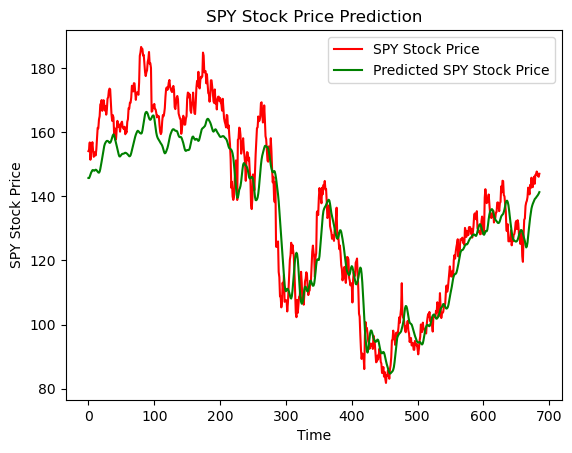

In [20]:
plt.plot(real_stock_price, color = 'red', label = 'SPY Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted SPY Stock Price')
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()

In [21]:
X_train.shape

(2000, 60, 1)

In [22]:
model = build_model(BATCH_SIZE, SEQ_LEN, OUTPUT_LEN)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Epoch 1/5
2000/2000 [==============================] - 33s 15ms/step - loss: 0.0666
Epoch 2/5
2000/2000 [==============================] - 28s 14ms/step - loss: 0.0094
Epoch 3/5
2000/2000 [==============================] - 28s 14ms/step - loss: 0.0041
Epoch 4/5
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0039
Epoch 5/5
2000/2000 [==============================] - 27s 14ms/step - loss: 0.0033


In [23]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)[:,0]
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

22/22 [==============================] - 1s 7ms/step


In [24]:
rmse = np.sqrt(np.mean((predicted_stock_price - real_stock_price)**2))
rmse

14.160937861896599

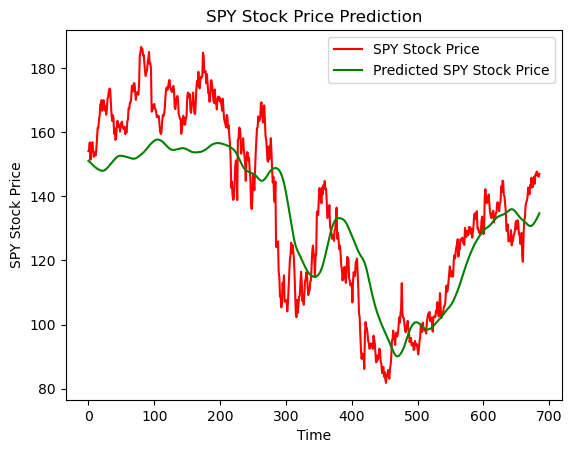

In [25]:
plt.plot(real_stock_price, color = 'red', label = 'SPY Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted SPY Stock Price')
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()

C:\Users\butel\AppData\Local\Temp\ipykernel_27368\3789539289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predicted_stock_price


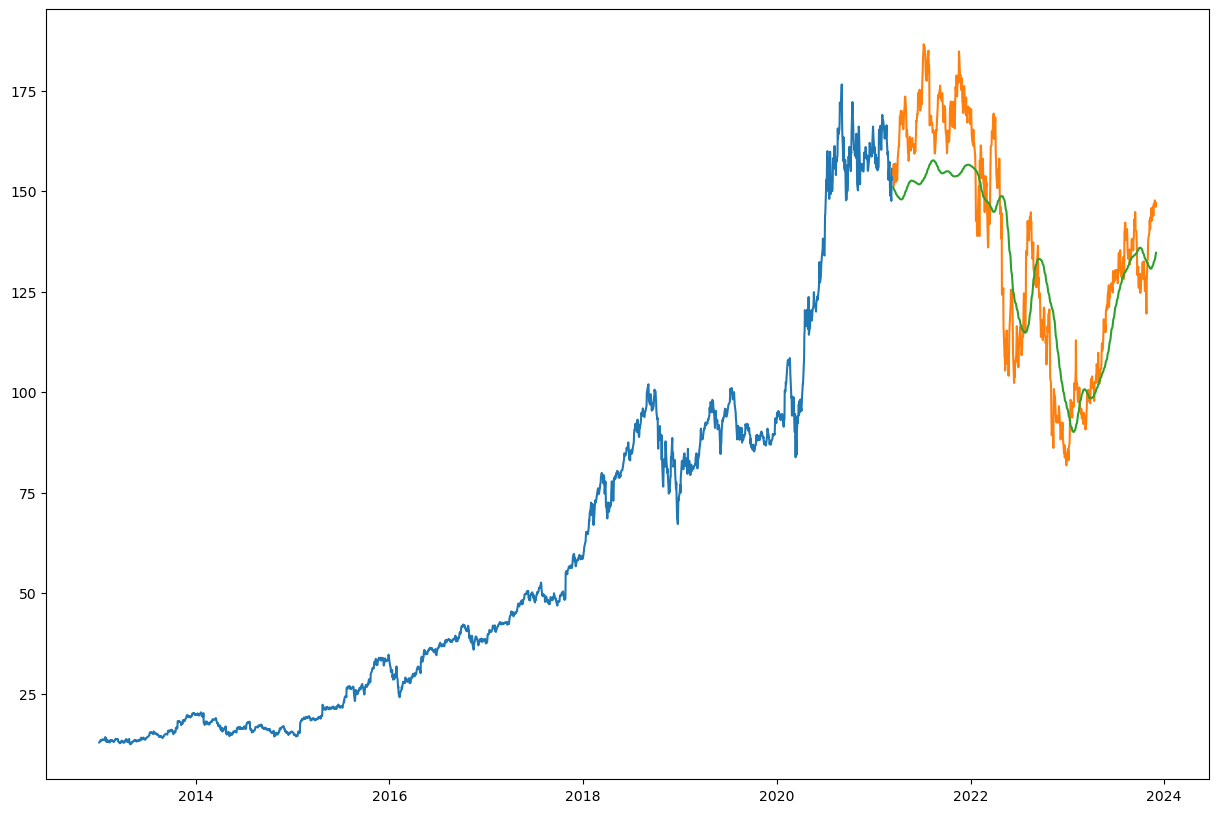

In [26]:
train = data[:-len(X_test)]
test = data[-(len(X_test)):]
test['Predictions'] = predicted_stock_price


plt.figure(figsize=(15, 10))
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])

In [27]:
#PREPARING DATA WITH THE HELP OF FUNCTIONS:
data = df['Close'].filter(['AMZN'])
data.columns = ['Close']
data_np = np.array(data.values).reshape(data.shape[0], 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_np)

data_len = scaled_data.shape[0]
training_data_len = math.ceil(data_len*0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len:]

train_seqs, train_targets = build_seqs(train_data, 60, 1, 3)
test_seqs, test_targets = build_seqs(test_data, 60, 1, 3)

In [28]:
train_seqs = train_seqs.reshape(train_seqs.shape[0], train_seqs.shape[1])
train_targets = train_targets.reshape(train_targets.shape[0], train_targets.shape[1])
test_seqs = test_seqs.reshape(test_seqs.shape[0], -1)
test_targets = test_targets.reshape(test_targets.shape[0], -1)

In [29]:
model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(train_seqs, train_targets, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Epoch 1/5
2137/2137 [==============================] - 31s 14ms/step - loss: 0.0043
Epoch 2/5
2137/2137 [==============================] - 28s 13ms/step - loss: 0.0032
Epoch 3/5
2137/2137 [==============================] - 29s 13ms/step - loss: 0.0033
Epoch 4/5
2137/2137 [==============================] - 30s 14ms/step - loss: 0.0028
Epoch 5/5
2137/2137 [==============================] - 32s 15ms/step - loss: 0.0033


In [30]:
predicted_stock_price = model.predict(test_seqs)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)[:,0]
real_stock_price = scaler.inverse_transform(test_targets.reshape(-1, 1))[2::3, 0]

16/16 [==============================] - 1s 8ms/step


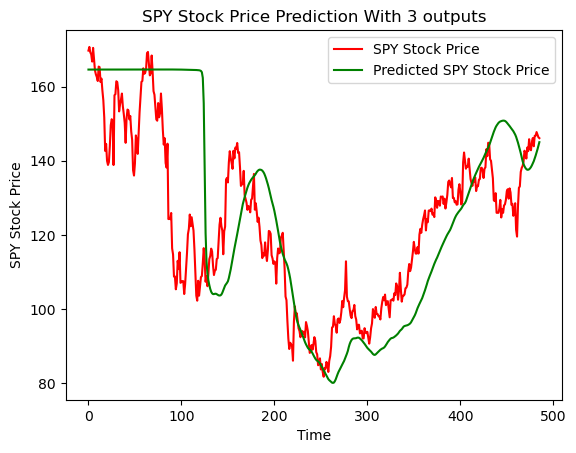

In [31]:
plt.plot(real_stock_price, color = 'red', label = 'SPY Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted SPY Stock Price')
plt.title('SPY Stock Price Prediction With 3 outputs')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()

In [32]:
Daily_Returns = pd.concat([df['Close'].pct_change()], axis = 1, keys =['Daily_Returns'])
Daily_Returns.iloc[0] = 0
Daily_Returns

Daily_Returns                                                  
                    AMZN        BA       JPM        MA       SPY         V
Date                                                                      
2013-01-02      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2013-01-03      0.004547  0.005190 -0.002015  0.001431 -0.002259  0.000772
2013-01-04      0.002592  0.002840  0.017725 -0.000039  0.004391  0.008167
2013-01-07      0.035925 -0.020080  0.001102  0.017330 -0.002732  0.007144
2013-01-08     -0.007748 -0.026270  0.001982 -0.003291 -0.002877  0.009310
...                  ...       ...       ...       ...       ...       ...
2023-11-27      0.006747 -0.003182 -0.002279 -0.008558 -0.001801 -0.000629
2023-11-28     -0.004738  0.013999  0.002285  0.000098  0.000990 -0.004722
2023-11-29     -0.004829  0.009264  0.005080  0.001980 -0.000703  0.005100
2023-11-30     -0.001572  0.032081  0.011405  0.009785  0.003937  0.009637
2023-12-01      0.006434  0.009671  0.004869  0.001281  0.005916 -0.000896

[2749 rows x 6 columns]

In [33]:
Log_Returns = pd.concat([np.log(df['Close'] / df['Close'].shift(1))], axis = 1, keys = ['Log_Returns'])
Log_Returns.iloc[0] = 0
Log_Returns

Log_Returns                                                  
                  AMZN        BA       JPM        MA       SPY         V
Date                                                                    
2013-01-02    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2013-01-03    0.004537  0.005177 -0.002017  0.001430 -0.002262  0.000772
2013-01-04    0.002589  0.002836  0.017570 -0.000039  0.004382  0.008134
2013-01-07    0.035295 -0.020285  0.001101  0.017181 -0.002736  0.007119
2013-01-08   -0.007778 -0.026621  0.001980 -0.003297 -0.002882  0.009267
...                ...       ...       ...       ...       ...       ...
2023-11-27    0.006724 -0.003187 -0.002282 -0.008594 -0.001803 -0.000629
2023-11-28   -0.004750  0.013902  0.002282  0.000098  0.000990 -0.004733
2023-11-29   -0.004841  0.009221  0.005067  0.001978 -0.000704  0.005087
2023-11-30   -0.001573  0.031577  0.011340  0.009737  0.003930  0.009591
2023-12-01    0.006414  0.009624  0.004857  0.001280  0.005898 -0.000896

[2749 rows x 6 columns]

In [34]:
df = df.join(Daily_Returns)
df = df.join(Log_Returns)
df

Close                                                   
                  AMZN          BA         JPM          MA         SPY   
Date                                                                     
2013-01-02   12.865500   64.583824   33.084862   47.807575  119.976471  \
2013-01-03   12.924000   64.919044   33.018192   47.875969  119.705414   
2013-01-04   12.957500   65.103409   33.603443   47.874088  120.231071   
2013-01-07   13.423000   63.796116   33.640476   48.703735  119.902573   
2013-01-08   13.319000   62.120178   33.707161   48.543430  119.557564   
...                ...         ...         ...         ...         ...   
2023-11-27  147.729996  219.300003  153.190002  408.970001  454.480011   
2023-11-28  147.029999  222.369995  153.539993  409.010010  454.929993   
2023-11-29  146.320007  224.429993  154.320007  409.820007  454.609985   
2023-11-30  146.089996  231.630005  156.080002  413.829987  456.399994   
2023-12-01  147.029999  233.869995  156.839996  414.359985  459.100006   

                              High                                      ...   
                     V        AMZN          BA         JPM          MA  ...   
Date                                                                    ...   
2013-01-02   35.941452   12.905000   64.801703   33.336739   47.807575  ...  \
2013-01-03   35.969200   13.044000   65.346421   33.151539   48.293832  ...   
2013-01-04   36.262970   12.990000   65.379941   33.655300   47.988393  ...   
2013-01-07   36.522041   13.486500   65.103383   33.699743   48.869667  ...   
2013-01-08   36.862068   13.449000   63.528001   33.707161   48.846227  ...   
...                ...         ...         ...         ...         ...  ...   
2023-11-27  254.139999  149.259995  219.529999  153.529999  412.720001  ...   
2023-11-28  252.940002  147.600006  224.800003  153.869995  410.640015  ...   
2023-11-29  254.229996  148.539993  224.990005  155.630005  412.079987  ...   
2023-11-30  256.679993  146.929993  233.000000  156.130005  414.160004  ...   
2023-12-01  256.450012  147.250000  235.380005  157.860001  416.600006  ...   

           Daily_Returns                               Log_Returns             
                     JPM        MA       SPY         V        AMZN        BA   
Date                                                                           
2013-01-02      0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  \
2013-01-03     -0.002015  0.001431 -0.002259  0.000772    0.004537  0.005177   
2013-01-04      0.017725 -0.000039  0.004391  0.008167    0.002589  0.002836   
2013-01-07      0.001102  0.017330 -0.002732  0.007144    0.035295 -0.020285   
2013-01-08      0.001982 -0.003291 -0.002877  0.009310   -0.007778 -0.026621   
...                  ...       ...       ...       ...         ...       ...   
2023-11-27     -0.002279 -0.008558 -0.001801 -0.000629    0.006724 -0.003187   
2023-11-28      0.002285  0.000098  0.000990 -0.004722   -0.004750  0.013902   
2023-11-29      0.005080  0.001980 -0.000703  0.005100   -0.004841  0.009221   
2023-11-30      0.011405  0.009785  0.003937  0.009637   -0.001573  0.031577   
2023-12-01      0.004869  0.001281  0.005916 -0.000896    0.006414  0.009624   

                                                    
                 JPM        MA       SPY         V  
Date                                                
2013-01-02  0.000000  0.000000  0.000000  0.000000  
2013-01-03 -0.002017  0.001430 -0.002262  0.000772  
2013-01-04  0.017570 -0.000039  0.004382  0.008134  
2013-01-07  0.001101  0.017181 -0.002736  0.007119  
2013-01-08  0.001980 -0.003297 -0.002882  0.009267  
...              ...       ...       ...       ...  
2023-11-27 -0.002282 -0.008594 -0.001803 -0.000629  
2023-11-28  0.002282  0.000098  0.000990 -0.004733  
2023-11-29  0.005067  0.001978 -0.000704  0.005087  
2023-11-30  0.011340  0.009737  0.003930  0.009591  
2023-12-01  0.004857  0.001280  0.005898 -0.000896  

[2749 row

In [35]:
data = df['Daily_Returns'].filter(['AMZN'])
data.columns = ['Daily_Returns']
data_np = np.array(data.values).reshape(data.shape[0], 1)

In [36]:
X_all = []
y_all = []
for i in range(60, data_len - DAYS_AFTER):
    X_all.append(data_np[i-60:i, 0])
    y_all.append(data_np[i + DAYS_AFTER, 0])
X_all, y_all = np.array(X_all), np.array(y_all)
X_all = np.reshape(X_all, (X_all.shape[0], X_all.shape[1], 1))

X_train = X_all[:2000]
y_train = y_all[:2000]
X_test = X_all[2000:]
y_test = y_all[2000:]

In [37]:
model = build_model(BATCH_SIZE, SEQ_LEN, OUTPUT_LEN)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Epoch 1/5
2000/2000 [==============================] - 31s 14ms/step - loss: 3.7464e-04
Epoch 2/5
2000/2000 [==============================] - 28s 14ms/step - loss: 3.7464e-04
Epoch 3/5
2000/2000 [==============================] - 28s 14ms/step - loss: 3.7463e-04
Epoch 4/5
2000/2000 [==============================] - 28s 14ms/step - loss: 3.7478e-04
Epoch 5/5
2000/2000 [==============================] - 29s 15ms/step - loss: 3.7510e-04


In [38]:
predicted_stock_price = model.predict(X_test)

22/22 [==============================] - 1s 7ms/step


In [39]:
rmse = np.sqrt(np.mean((predicted_stock_price - real_stock_price)**2))
rmse

125.04431236367186

C:\Users\butel\AppData\Local\Temp\ipykernel_27368\886885624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predicted_stock_price


Text(0, 0.5, 'Daily_Returns')

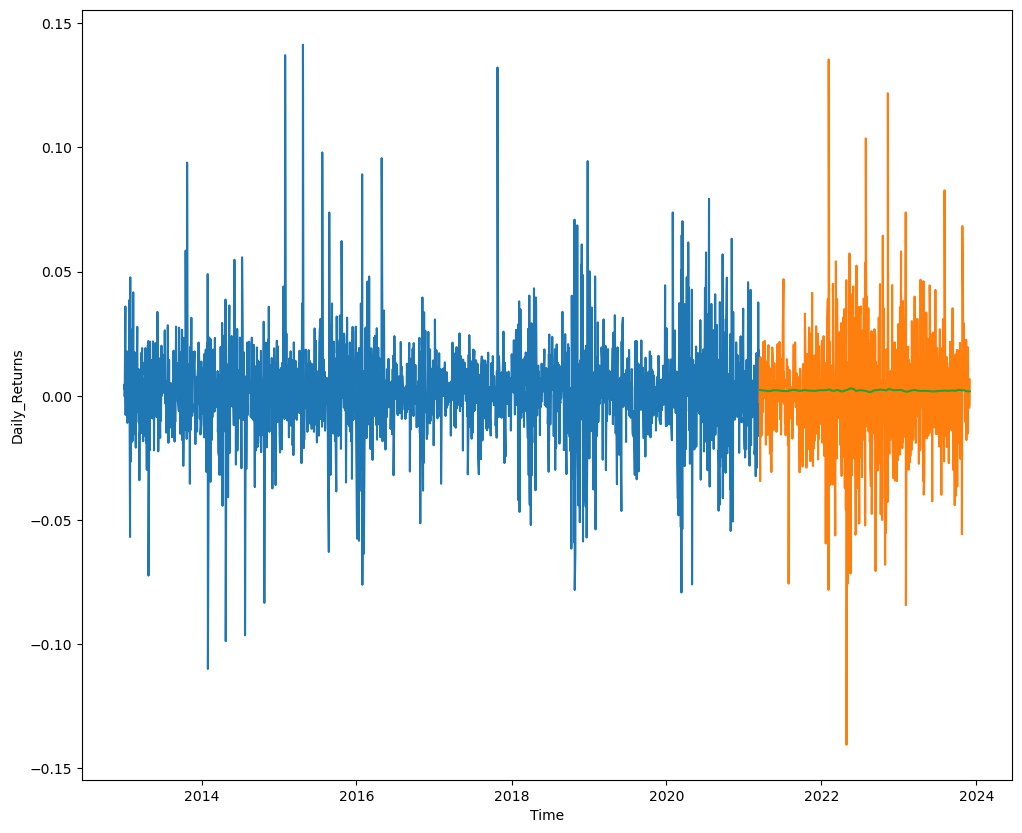

In [40]:
train = data[:-len(X_test)]
test = data[-(len(X_test)):]
test['Predictions'] = predicted_stock_price


plt.figure(figsize=(12, 10))
plt.plot(train['Daily_Returns'])
plt.plot(test[['Daily_Returns', 'Predictions']])
plt.xlabel('Time')
plt.ylabel('Daily_Returns')

In [41]:
data = df['Close'].filter(['AMZN'])
data.columns = ['Close']
data_np = np.array(data.values).reshape(data.shape[0], 1)

train = data_np[:-len(X_test)]
test = pd.DataFrame(data_np[-(len(X_test)):])
test['Predictions'] = predicted_stock_price

data_np

array([[ 12.86550045],
       [ 12.92399979],
       [ 12.95750046],
       ...,
       [146.32000732],
       [146.08999634],
       [147.02999878]])

In [42]:
start = data_np[-len(X_test)]
normal_predictions = from_returns_to_normal(start, data_np[-len(X_test):])

C:\Users\butel\AppData\Local\Temp\ipykernel_27368\3402040695.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  normal[0] = start_value
C:\Users\butel\AppData\Local\Temp\ipykernel_27368\3402040695.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  normal[i] = normal[i-1] * returns[i-1] + normal[i-1]
C:\Users\butel\AppData\Local\Temp\ipykernel_27368\3402040695.py:5: RuntimeWarning: overflow encountered in multiply
  normal[i] = normal[i-1] * returns[i-1] + normal[i-1]


In [44]:
data = df['Log_Returns'].filter(['AMZN'])
data.columns = ['Log_Returns']
data_np = np.array(data.values).reshape(data.shape[0], 1)

X_all = []
y_all = []
for i in range(60, data_len - DAYS_AFTER):
    X_all.append(data_np[i-60:i, 0])
    y_all.append(data_np[i + DAYS_AFTER, 0])
X_all, y_all = np.array(X_all), np.array(y_all)
X_all = np.reshape(X_all, (X_all.shape[0], X_all.shape[1], 1))

X_train = X_all[:2000]
y_train = y_all[:2000]
X_test = X_all[2000:]
y_test = y_all[2000:]

In [45]:
model = build_model(BATCH_SIZE, SEQ_LEN, OUTPUT_LEN)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Epoch 1/5
2000/2000 [==============================] - 30s 14ms/step - loss: 3.7174e-04
Epoch 2/5
2000/2000 [==============================] - 27s 14ms/step - loss: 3.7293e-04
Epoch 3/5
2000/2000 [==============================] - 27s 14ms/step - loss: 3.7163e-04
Epoch 4/5
2000/2000 [==============================] - 27s 14ms/step - loss: 3.7246e-04
Epoch 5/5
2000/2000 [==============================] - 28s 14ms/step - loss: 3.7175e-04


In [46]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)[:,0]
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

22/22 [==============================] - 1s 8ms/step


In [47]:
rmse = np.sqrt(np.mean((predicted_stock_price - real_stock_price)**2))
rmse, r2_score(real_stock_price, predicted_stock_price)

(4.210386563779454, -0.00023367548746500155)

C:\Users\butel\AppData\Local\Temp\ipykernel_27368\2155892311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predicted_stock_price


Text(0, 0.5, 'Log_Returns')

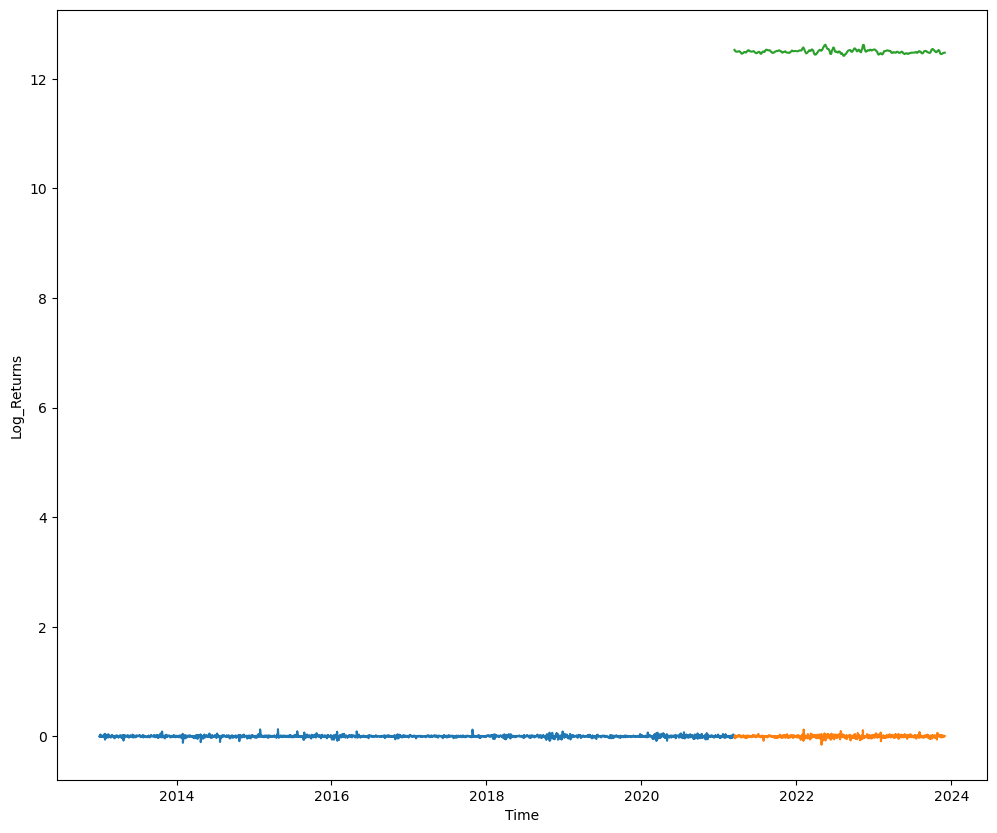

In [48]:
train = data[:-len(X_test)]
test = data[-(len(X_test)):]
test['Predictions'] = predicted_stock_price


plt.figure(figsize=(12, 10))
plt.plot(train['Log_Returns'])
plt.plot(test[['Log_Returns', 'Predictions']])
plt.xlabel('Time')
plt.ylabel('Log_Returns')

In [49]:
from scipy.fftpack import fft
 
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

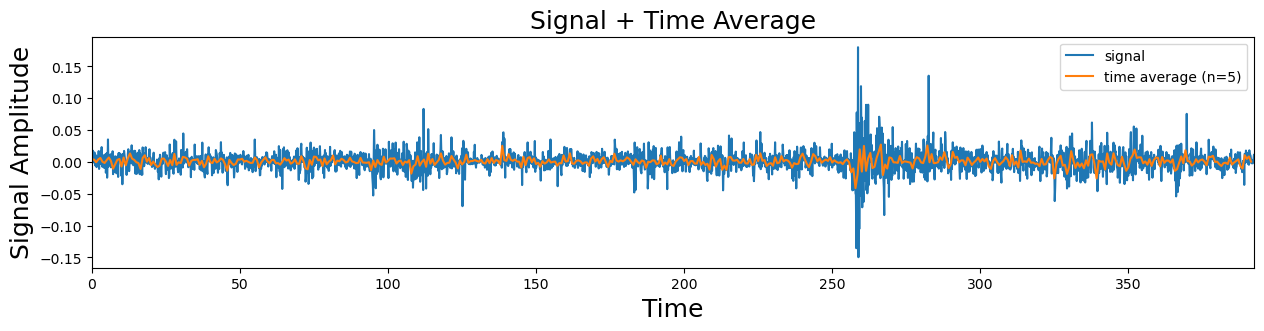

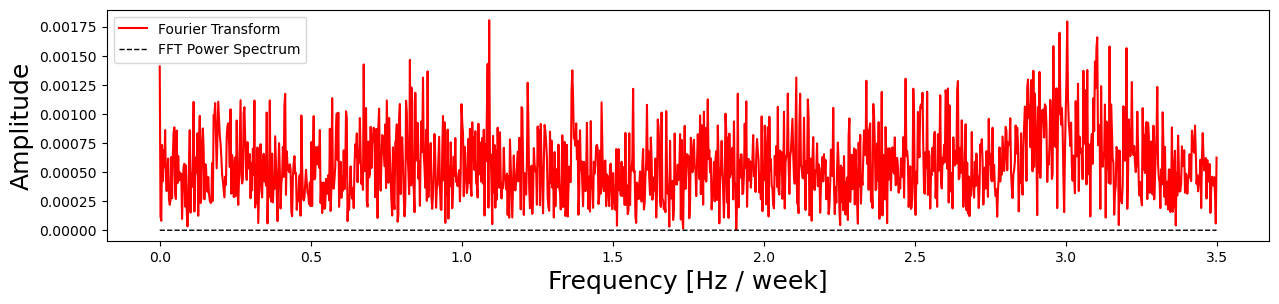

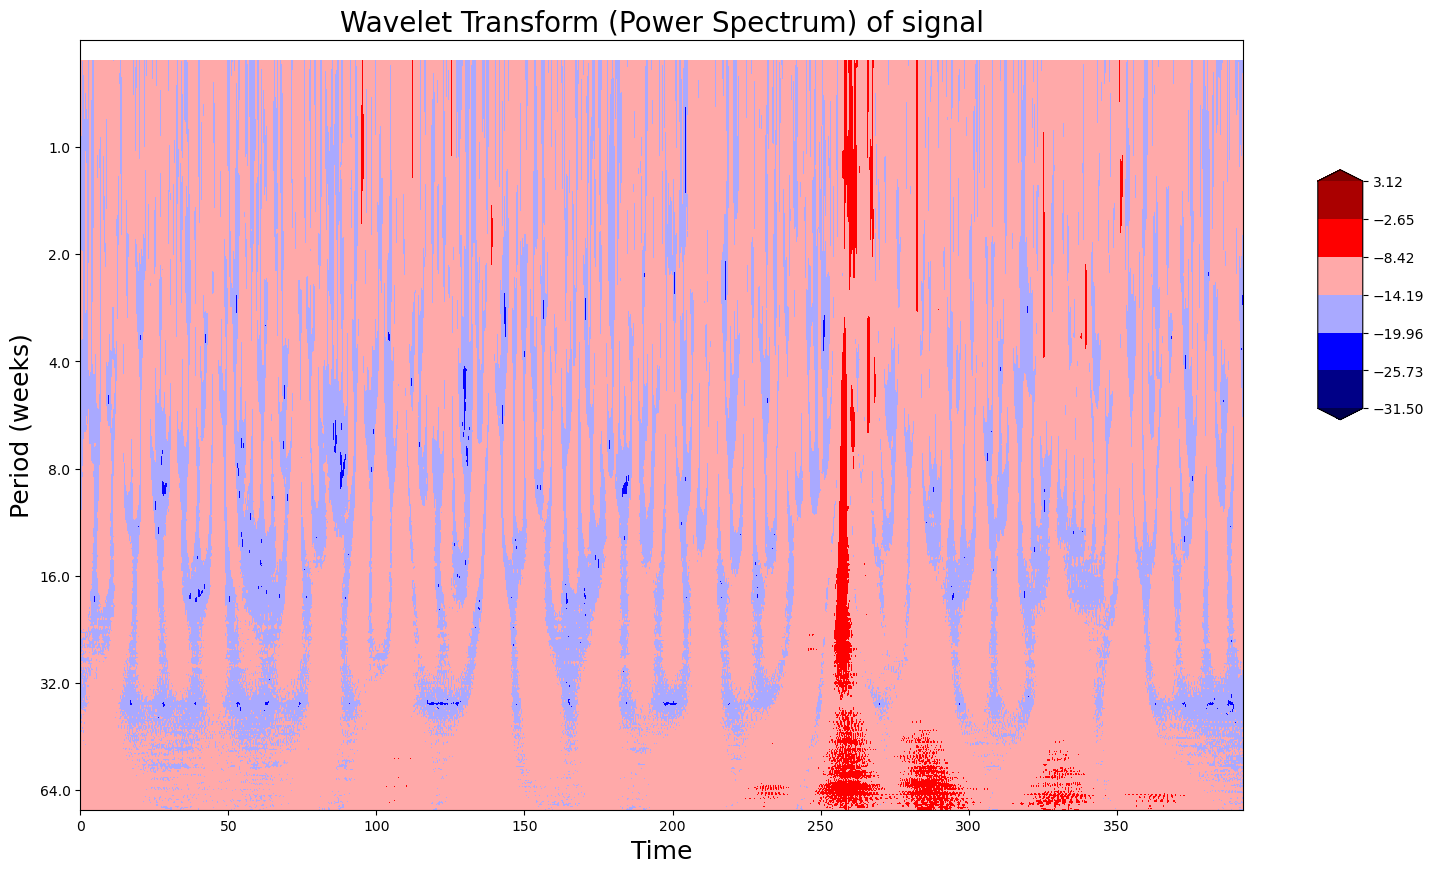

In [50]:
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave


def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (weeks)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    #levels = [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    log_power = np.log2(power.squeeze()[0])
    power_max = max(log_power)
    power_min = min(log_power)
    #contourlevels = np.log2(levels)
    std = np.std(log_power)
    mean = np.mean(log_power)
    median = np.median(log_power)
    contourlevels = np.linspace(median - 5*std , median + 5 *std, 7)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()
 
def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / week]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()
 

df_nino_1 = df['Daily_Returns'].filter(['JPM'])
df_nino_1.reset_index(inplace=True, drop=True)
df_nino_1.loc[0] = 0

#df_nino = pd.read_table(dataset)
df_nino = df_nino_1
N = df_nino.shape[0]
t0=0
dt=1/7
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
 
scales = np.arange(1, 128)
plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
plot_wavelet(time, signal, scales, waveletname='mexh')

In [51]:
df_nino_1 = df[['Daily_Returns']]
df_nino_1.reset_index(inplace=True, drop=True)
df_nino_1.loc[0] = 0

df_nino = df_nino_1


N = df_nino.shape[0]
t0=0
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()
 
scales = np.arange(1, 256)
[coefficients, frequencies] = pywt.cwt(signal, scales, 'cmor', dt)

C:\ProgramData\Anaconda3\envs\baza\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


In [216]:
#Preparing data to make it sequence-like
data = Daily_Returns['Daily_Returns'].reset_index().drop('Date', axis = 1)
columns_names = data.columns
data_np_returns = np.array(data.values).reshape(data.shape[1], data.shape[0], 1)

#Lengths of original data(days) and training data
data_len = data_np_returns.shape[1]   
training_data_len = math.ceil(data_len*0.8)

train_data = data_np_returns[:, :training_data_len]
test_data = data_np_returns[:, training_data_len:]

train_data.shape, test_data.shape

((6, 2200, 1), (6, 549, 1))

In [68]:
#CREATING TRAIN AND TEST SEQUENCIES AND OUTPUTS FOR WAVELET TRANSFORM PREDICTIONS WITH CONVS

train_seqs = []
y_train_cwt = []
test_seqs = []
y_test_cwt = []
for firm_close in train_data:
    firm_train_seqs, firm_y_seqs = build_seqs_with_1_out(firm_close, 60, 1, 3)
    train_seqs.append(firm_train_seqs)
    y_train_cwt.append(firm_y_seqs)

for firm_close in test_data:
    firm_seqs, firm_y_seqs = build_seqs_with_1_out(firm_close, 60, 1, 3)
    test_seqs.append(firm_seqs)
    y_test_cwt.append(firm_y_seqs)


train_seqs = np.asarray(train_seqs)
y_train_cwt = np.asarray(y_train_cwt)
test_seqs = np.asarray(test_seqs)
y_test_cwt = np.asarray(y_test_cwt)

In [54]:
#TRANSORMING TRAIN DATA WITH WAVELET TRANSORM

data = train_seqs
scales = range(1, 2*SEQ_LEN + 1)
waveletname = 'morl'
num_firms = data.shape[0]
train_size = data.shape[1]

#test_data_cwt = np.ndarray(shape=(num_firms, train_size, 2*SEQ_LEN, SEQ_LEN, 1))
train_data_cwt = np.ndarray(shape=(num_firms, train_size, 2*SEQ_LEN, SEQ_LEN, 1))
for j in range(num_firms): 
    for ii in range(0,train_size):
        if ii % 1000 == 0:
            print(ii)
        signal = data[j, ii, :, 0]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        train_data_cwt[j, ii, :, :, 0] = coeff_

0
1000
2000
0
1000
2000
0
1000
2000
0
1000
2000
0
1000
2000
0
1000
2000


In [69]:
#TRANSORMING TEST DATA WITH WAVELET TRANSORM


data = test_seqs
scales = range(1, 2*SEQ_LEN + 1)
waveletname = 'morl'
num_firms = data.shape[0]
train_size = data.shape[1]

#test_data_cwt = np.ndarray(shape=(num_firms, train_size, 2*SEQ_LEN, SEQ_LEN, 1))
test_data_cwt = np.ndarray(shape=(num_firms, train_size, 2*SEQ_LEN, SEQ_LEN, 1))
for j in range(num_firms): 
    for ii in range(0,train_size):
        if ii % 1000 == 0:
            print(ii)
        signal = data[j, ii, :, 0]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        test_data_cwt[j, ii, :, :, 0] = coeff_

0
0
0
0
0
0


In [55]:
# train_seqs = train_seqs.reshape(train_seqs.shape[:-1])
# test_seqs = test_seqs.reshape(test_seqs.shape[:-1])

In [74]:
model = build_conv_model(BATCH_SIZE, SEQ_LEN, OUTPUT_LEN)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 60, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 120, 60, 64)       640       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 60, 64)       36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                             

In [75]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mean_absolute_error')

model.fit(train_data_cwt[0], y_train_cwt[0], batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Epoch 1/5
2137/2137 [==============================] - 11s 4ms/step - loss: 0.0097
Epoch 2/5
2137/2137 [==============================] - 8s 4ms/step - loss: 0.0092
Epoch 3/5
2137/2137 [==============================] - 8s 4ms/step - loss: 0.0087
Epoch 4/5
2137/2137 [==============================] - 8s 4ms/step - loss: 0.0083
Epoch 5/5
2137/2137 [==============================] - 8s 4ms/step - loss: 0.0079


In [80]:
predictions_test = model.predict(test_data_cwt[0])
rmse = np.sqrt(np.mean((y_test_cwt[0] - predictions_test[0])**2))
rmse

16/16 [==============================] - 0s 24ms/step


0.013320290925748934

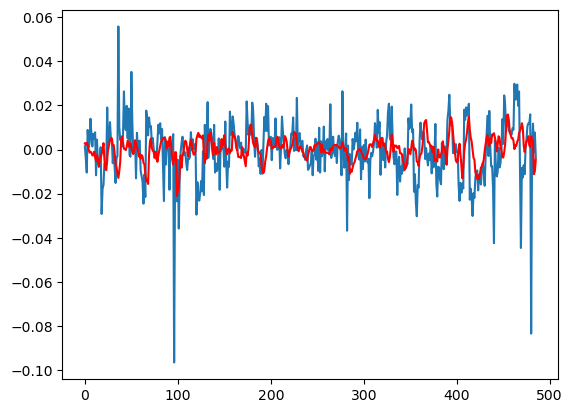

In [185]:
plt.plot(y_test_cwt[0].reshape(-1, 1))
plt.plot(predictions_test, color='red')

In [198]:
#COME BACK TO NORMAL VALUES

data = df['Close'].filter(['AMZN'])
data.columns = ['Close']
data_np = np.array(data.values).reshape(data.shape[0], 1)

start = data_np[-len(y_test_cwt[0])]
normal_known_values_with_shift = data_np[-len(y_test_cwt[0]) - DAYS_AFTER - 1 :-DAYS_AFTER]

PREDICTIONS_TEST_NORMAL = from_returns_to_normal_predictions(normal_known_values_with_shift, predictions_test)
TEST_NORMAL = from_returns_to_normal(start, y_test_cwt[0])

C:\Users\butel\AppData\Local\Temp\ipykernel_27368\2944406434.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  normal[0] = normal_known_values[0]
C:\Users\butel\AppData\Local\Temp\ipykernel_27368\2944406434.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  normal[i] = normal_known_values[i-1] * (1 + returns[i-1])


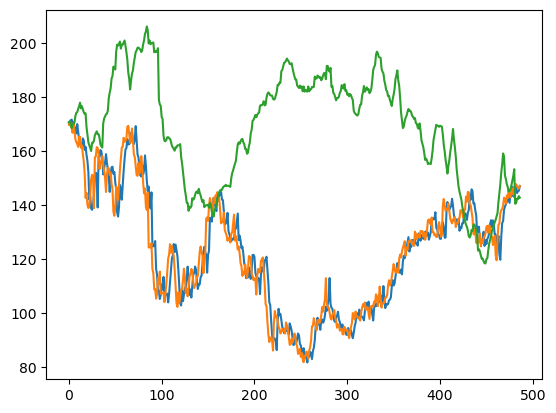

In [199]:
plt.plot(PREDICTIONS_TEST_NORMAL)
plt.plot(data_np[-len(PREDICTIONS_TEST_NORMAL):])
plt.plot(TEST_NORMAL)

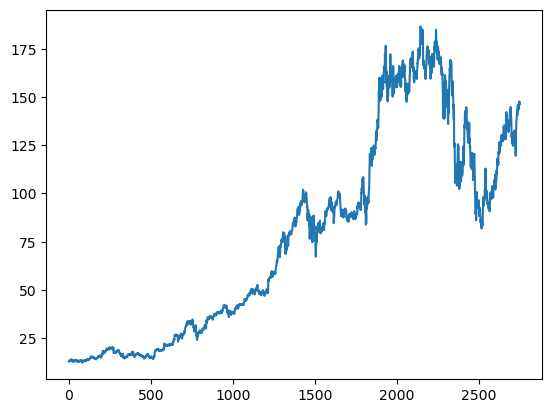

In [204]:
plt.plot(data_np)